<a href="https://colab.research.google.com/github/jyoung1996/beir/blob/main/cs224n_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Mar 13 02:02:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install the beir PyPI package
!pip install beir
!pip install umap 

  Using cached umap-0.1.1-py3-none-any.whl


In [3]:
import json
import random
import pathlib, os
import logging
from collections import Counter
from tqdm import tqdm
from beir import util, LoggingHandler
from beir import util
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval import models
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES

/usr/local/lib/python3.7/dist-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
#### /print debug information to stdout

In [5]:
datasets = ['trec-covid', 'nfcorpus', 'nq', 'scifact']
dataset = "msmarco"
url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
out_dir = os.path.join(os.getcwd(), "datasets")
data_path = util.download_and_unzip(url, out_dir)
print("Dataset downloaded here: {}".format(data_path))

Dataset downloaded here: /content/datasets/msmarco


In [6]:
dataset = "msmarco"
data_path_domain = f"datasets/{dataset}"

corpus, queries, qrels_train = GenericDataLoader(data_path_domain).load(split="train") 
_, _, qrels_dev = GenericDataLoader(data_path_domain).load(split="dev") 
_, _, qrels_test = GenericDataLoader(data_path_domain).load(split="test") 

2022-03-13 02:03:28 - Loading Corpus...


  0%|          | 0/8841823 [00:00<?, ?it/s]

2022-03-13 02:04:36 - Loaded 8841823 TRAIN Documents.
2022-03-13 02:04:37 - Doc Example: {'text': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.', 'title': ''}
2022-03-13 02:04:37 - Loading Queries...
2022-03-13 02:04:39 - Loaded 502939 TRAIN Queries.
2022-03-13 02:04:39 - Query Example: )what was the immediate impact of the success of the manhattan project?
2022-03-13 02:04:39 - Loading Corpus...


  0%|          | 0/8841823 [00:00<?, ?it/s]

2022-03-13 02:05:35 - Loaded 8841823 DEV Documents.
2022-03-13 02:05:35 - Doc Example: {'text': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.', 'title': ''}
2022-03-13 02:05:35 - Loading Queries...
2022-03-13 02:05:37 - Loaded 6980 DEV Queries.
2022-03-13 02:05:37 - Query Example: how many years did william bradford serve as governor of plymouth colony?
2022-03-13 02:05:39 - Loading Corpus...


  0%|          | 0/8841823 [00:00<?, ?it/s]

2022-03-13 02:06:42 - Loaded 8841823 TEST Documents.
2022-03-13 02:06:42 - Doc Example: {'text': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.', 'title': ''}
2022-03-13 02:06:42 - Loading Queries...
2022-03-13 02:06:44 - Loaded 43 TEST Queries.
2022-03-13 02:06:44 - Query Example: anthropological definition of environment


In [173]:
!pwd

/content


In [7]:
import ast
queries_original = []
with open("./datasets/msmarco/queries.jsonl") as f:
  for line in f:
    line = ast.literal_eval(line)
    queries_original.append(line)


import ast
corpus_original = []
with open("./datasets/msmarco/corpus.jsonl") as f:
  for line in tqdm(f):
    line = ast.literal_eval(line)
    corpus_original.append(line)

8841823it [04:08, 35612.54it/s]


In [8]:
TRAIN_DOCS = [] 
for k, item in qrels_train.items():
    for doc_k, val in item.items():
        TRAIN_DOCS.append(doc_k)
DEV_DOCS = []
for k, item in qrels_dev.items():
    for doc_k, val in item.items():
        DEV_DOCS.append(doc_k)

exits = {}
for k in TRAIN_DOCS:
  exits[k] = 1
for k in DEV_DOCS:
  exits[k] = 1
OTHER_DOCS = []
for k, v in tqdm(corpus.items()):
  if k not in exits:
    OTHER_DOCS.append(k)

# all_docs = [k for k, v in corpus.items()]
random.seed(1)
ALL_DOCS = DEV_DOCS.copy()
ALL_DOCS.extend(random.sample(TRAIN_DOCS, 50000))
ALL_DOCS.extend(random.sample(OTHER_DOCS, 150000))
random_subsample = {}
for key in ALL_DOCS:
    random_subsample[key] = corpus[key] 
random_text = [v['text'] for k, v in tqdm(random_subsample.items())]

num_doc = len(random_text)

100%|██████████| 207215/207215 [00:00<00:00, 828576.32it/s]


In [ ]:
len(num_doc)

207215

In [9]:
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sentence_transformers import util
import seaborn as sns
!pip uninstall umap -y 
!pip install umap-learn
import umap.umap_ as umap
import torch
import matplotlib
import random 

sentence_model = SentenceTransformer('bert-base-uncased')
embeddings = sentence_model.encode(random_text, show_progress_bar=True)

Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Successfully uninstalled umap-0.1.1
2022-03-13 02:11:24 - Load pretrained SentenceTransformer: bert-base-uncased
2022-03-13 02:11:26 - No sentence-transformers model found with name /root/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.


Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2022-03-13 02:11:30 - Use pytorch device: cuda


Batches:   0%|          | 0/6476 [00:00<?, ?it/s]

In [75]:
""" Dimensionality Reduction with PCA to figure out the num_axis for UMAP """ 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# get the number of axis from PCA  
def get_num_axis(initial=2): 
  num_axis = initial
  sumvariance = 0 
  while sumvariance <0.60: 
    sumvariance = 0 
    pca = PCA(n_components = num_axis)
    embed2_std = StandardScaler().fit_transform(embeddings)
    pca_emb2 = pca.fit_transform(embed2_std)
    sumvariance = np.sum(pca.explained_variance_ratio_)
    num_axis+=1
  return num_axis 

52


In [ ]:
""" UMAP Dimensionality Reduction (cosine and euclidean) """ 
# Run time: 15-20 minutes on P100

# num_axis = get_num_axis(initial=50) # 50 empirically determined as initialization
num_axis = 30 

# Cosine Metric
# embed_umap_cos = umap.UMAP(n_neighbors=15, 
#                             n_components=num_axis, 
#                             metric='cosine',
#                             min_dist=0.0,
#                             low_memory=False).fit_transform(embeddings)

# Euclidean Metric 
embed_umap_euc = umap.UMAP(n_neighbors=15, 
                            n_components=num_axis, 
                            metric='euclidean',
                            min_dist=0.0,
                            low_memory=False).fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [143]:
""" Gap Statistic Code to find Optimal Number of Clusters """ 
# Run time: 5-10 minutes on P100
import numpy as np
!pip install --upgrade gap-stat
from gap_statistic import OptimalK

# optimalK_cos = OptimalK(parallel_backend='None')
optimalK_euc = OptimalK(parallel_backend='None')

max_K = 30 # arbitrarily chosen, as long as an interior solution is found. 

# n_clusters_cos = optimalK_cos(embed_umap_cos, cluster_array=np.arange(1, max_K))
n_clusters_euc = optimalK_euc(embed_umap_euc, cluster_array=np.arange(1, max_K))

# print('Optimal clusters for Umap Embeddings (Cosine): ', n_clusters_cos)
print('Optimal clusters for Umap Embeddings (Euclidean): ', n_clusters_euc)

Optimal clusters for Umap Embeddings (Euclidean):  26


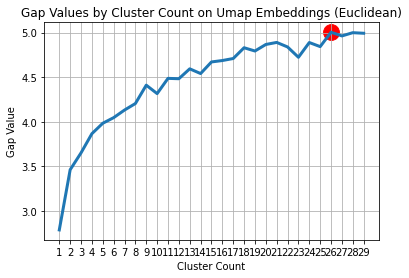

In [144]:
""" Gap Statistic Plot (Euclidean UMAP) """ 
import matplotlib.pyplot as plt 

# Euclidean 
plt.plot(optimalK_euc.gap_df.n_clusters, optimalK_euc.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK_euc.gap_df[optimalK_euc.gap_df.n_clusters == n_clusters_euc].n_clusters,
            optimalK_euc.gap_df[optimalK_euc.gap_df.n_clusters == n_clusters_euc].gap_value, s=250, c='r')
plt.grid(True)
plt.xticks(range(1,max_K))
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count on Umap Embeddings (Euclidean)')
plt.show()

In [ ]:
""" Gap Statistic Plot (Cosine UMAP)  """ 
# # Cosine 
# plt.plot(optimalK_cos.gap_df.n_clusters, optimalK_cos.gap_df.gap_value, linewidth=3)
# plt.scatter(optimalK_cos.gap_df[optimalK_cos.gap_df.n_clusters == n_clusters_cos].n_clusters,
#             optimalK_cos.gap_df[optimalK_cos.gap_df.n_clusters == n_clusters_cos].gap_value, s=250, c='r')
# plt.grid(True)
# plt.xticks(range(1,max_K))
# plt.xlabel('Cluster Count')
# plt.ylabel('Gap Value')
# plt.title('Gap Values by Cluster Count on Umap Embeddings (Cosine)')
# plt.show()

In [145]:
""" K-Means Clustering """ 
from sklearn.cluster import KMeans

num_clusters = n_clusters_euc
# Define kmeans model
clustering_model = KMeans(n_clusters=num_clusters)
# Fit the embedding with kmeans clustering.
clustering_model.fit(embed_umap_euc) # clustering_model.fit(embed_umap_cos)
# Get the cluster id assigned to each news headline.
cluster_assignment = clustering_model.labels_

clustering_model.cluster_centers_.shape # (num_clusters, dimension) 

(26, 30)

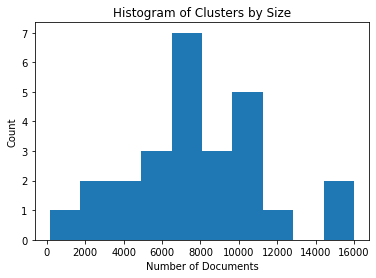

In [147]:
""" Sanity Check: Size of Clusters""" 
total = 0
sizes = [] 
for i in range(num_clusters): 
  clustered = (cluster_assignment == i)
  sizes.append(embed_umap_euc[clustered].shape[0])
  total += embed_umap_euc[clustered].shape[0]

assert total == num_doc, print("Unequal lengths!")

hist = plt.hist(sizes)
plt.ylabel("Count")
plt.xlabel("Number of Documents")
plt.title("Histogram of Clusters by Size")
plt.show() 

In [148]:
import numpy as np

dist = np.zeros((num_clusters, num_clusters))
for i in range(num_clusters): 
  for j in range(num_clusters): 
    dist[i,j] = np.linalg.norm(clustering_model.cluster_centers_[i] - clustering_model.cluster_centers_[j])


dist = np.triu(dist) 

temp = dist 
sorted_idx = [] 
sorted_value = [] 


n_ut = int(np.ceil(num_clusters*(num_clusters-1)/2))
for i in range(n_ut):
  maxValue = np.amax(temp)
  sorted_value.append(maxValue)
  result = np.where(temp == np.amax(temp))
  listOfCordinates = list(zip(result[0], result[1]))
  for cord in listOfCordinates:
      sorted_idx.append(cord)
      temp[cord[0],cord[1]] = 0

print(sorted_idx)
print(sorted_value)

[(10, 18), (18, 19), (3, 18), (6, 18), (18, 23), (16, 18), (14, 18), (9, 18), (0, 18), (18, 22), (18, 20), (18, 24), (18, 21), (13, 18), (15, 18), (4, 18), (1, 18), (8, 18), (12, 18), (2, 18), (17, 18), (7, 18), (11, 18), (5, 18), (18, 25), (10, 14), (6, 10), (5, 10), (6, 19), (14, 19), (9, 10), (4, 10), (8, 10), (10, 21), (3, 14), (10, 13), (2, 10), (8, 19), (5, 19), (3, 6), (9, 19), (19, 21), (4, 19), (2, 19), (3, 5), (3, 9), (10, 24), (3, 21), (10, 15), (10, 20), (15, 19), (3, 13), (3, 4), (3, 8), (19, 24), (2, 3), (14, 16), (14, 22), (9, 22), (6, 22), (6, 16), (1, 10), (0, 8), (8, 22), (8, 13), (3, 20), (19, 20), (0, 6), (5, 23), (8, 23), (10, 12), (0, 14), (9, 16), (10, 25), (3, 15), (0, 9), (13, 19), (8, 16), (3, 24), (13, 15), (0, 5), (5, 16), (12, 19), (1, 19), (6, 17), (7, 10), (16, 21), (21, 22), (15, 22), (1, 3), (13, 16), (0, 15), (0, 21), (6, 13), (5, 13), (5, 22), (20, 22), (4, 16), (6, 23), (14, 23), (4, 22), (6, 25), (0, 2), (2, 16), (2, 23), (2, 22), (13, 24), (1, 22),

In [149]:
# Furthest Clusters 
furthest_pair = sorted_idx[0] 
print("Furthest Clusters:", "Clusters ", furthest_pair[0], furthest_pair[1])

# Randomly pick one of these clusters as "home", the other as "away"
home = np.random.choice(furthest_pair,1)
away = furthest_pair[0] 
if away == home: 
  away = furthest_pair[1] 

# Sort the (home, other) pairs from furthest to closest 
home_cluster = home
sorted_idx_home = [] 

for i in range(len(sorted_idx)): 
  tmp = list(sorted_idx[i]) 
  # print(tmp)
  if tmp[0] == home_cluster or tmp[1] == home_cluster: 
    if tmp[1] == home_cluster: 
      # print(type(sorted_idx[i]))
      lst_sorted_idx = list(sorted_idx[i])
      # print(lst_sorted_idx)
      lst_sorted_idx[1] = tmp[0] 
      lst_sorted_idx[0] = tmp[1] 
      sorted_idx_home.append(lst_sorted_idx)
    else:
      sorted_idx_home.append(sorted_idx[i])

print(f"Sorted (Furthest to Closest) Idx from {home_cluster}:", sorted_idx_home)

# Closest to home
closest_neighbor = sorted_idx_home[-1][1] 

Furthest Clusters: Clusters  10 18
Sorted (Furthest to Closest) Idx from [10]: [(10, 18), (10, 14), [10, 6], [10, 5], [10, 9], [10, 4], [10, 8], (10, 21), (10, 13), [10, 2], (10, 24), (10, 15), (10, 20), [10, 1], (10, 12), (10, 25), [10, 7], (10, 11), (10, 17), (10, 22), [10, 0], (10, 23), (10, 16), (10, 19), [10, 3]]


Plot of (home,furthest) clusters along axis [1] and [2] (randomly chosen)


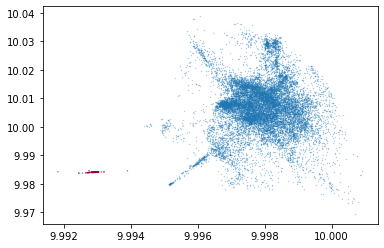

Plot of (home,nearest)) clusters along axis [1] and [2] (randomly chosen)


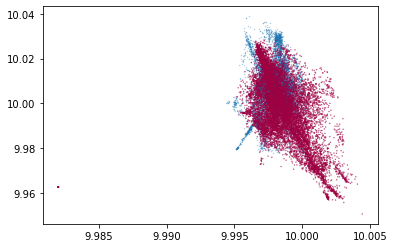

In [151]:
""" PLOTS """ 

# Randomly choose one of the n_components axis 
firstax = np.random.choice(np.arange(num_axis),1)
secondax = np.random.choice(np.arange(num_axis),1)
if secondax == firstax: 
  while secondax == firstax: 
    secondax = np.random.choice(np.arange(num_axis),1)

# Plot these pics for the furthest clusters
print(f"Plot of (home,furthest) clusters along axis {firstax} and {secondax} (randomly chosen)")
clustered1 = (cluster_assignment == home)
clustered2 = (cluster_assignment == away)
plt.scatter(embed_umap_euc[clustered1, firstax],
            embed_umap_euc[clustered1, secondax],
            # color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(embed_umap_euc[clustered2, firstax],
            embed_umap_euc[clustered2, secondax],
            c=cluster_assignment[clustered2],
            # color=(0.5, 0.5, 0.5),
            s=0.1,
            cmap='Spectral');
plt.show()
plt.savefig("home_furthest.png")

# Home and Closest Neighbor 

#### Code for the two closest pairs (not relating to home)
#### closest_pair = sorted_idx[-1] 
#### print("Furthest Clusters:", "Clusters ", closest_pair[0], closest_pair[1])

# Plot these pics for the closest clusters
print(f"Plot of (home,nearest) clusters along axis {firstax} and {secondax} (randomly chosen)")
clustered1 = (cluster_assignment == home)
clustered2 = (cluster_assignment == closest_neighbor)
plt.scatter(embed_umap_euc[clustered1, firstax],
            embed_umap_euc[clustered1, secondax],
            # color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(embed_umap_euc[clustered2, firstax],
            embed_umap_euc[clustered2, secondax],
            c=cluster_assignment[clustered2],
            # color=(0.5, 0.5, 0.5),
            s=0.1,
            cmap='Spectral');
plt.show()
plt.savefig("home_nearest.png")



In [159]:
remaining_sorted_idx_home = sorted_idx_home.copy()  # keep track of this
A = [] 
Asize = embed_umap_euc[cluster_assignment == home_cluster].shape[0]
# print(Asize)
A.append(home_cluster)
print("Starting from Cluster: ", home_cluster, "...")
idx = -1

while Asize < num_doc/2: # change this later 
  print(f"Added Cluster {sorted_idx_home[idx][1]}")
  A.append(sorted_idx_home[idx][1]) 
  Asize += embed_umap_euc[cluster_assignment == sorted_idx_home[idx][1]].shape[0]
  idx = idx-1 
  remaining_sorted_idx_home.pop()

print("Overall A Sample Size: ", Asize)
print("A Consists of Clusters: ", A)


Starting from Cluster:  [10] ...
Added Cluster 3
Added Cluster 19
Added Cluster 16
Added Cluster 23
Added Cluster 0
Added Cluster 22
Added Cluster 17
Added Cluster 11
Added Cluster 7
Added Cluster 25
Added Cluster 12
Added Cluster 1
Added Cluster 20
Overall A Sample Size:  110298
A Consists of Clusters:  [array([10]), 3, 19, 16, 23, 0, 22, 17, 11, 7, 25, 12, 1, 20]


In [160]:
# Remaining clusters list in distance from furthest to closest: 
remaining_sorted_idx_home

# Make B (second big group) 
B = [] 
Bsize = 0 
for i in range(len(remaining_sorted_idx_home)): 
  B.append(remaining_sorted_idx_home[i][1])
  Bsize += embed_umap_euc[cluster_assignment == remaining_sorted_idx_home[i][1]].shape[0]
print("Overall B Sample Size: ", Bsize)
print("B Consists of Clusters: ", B)



Overall B Sample Size:  96917
B Consists of Clusters:  [18, 14, 6, 5, 9, 4, 8, 21, 13, 2, 24, 15]


In [ ]:
# Make B,C,D.... 
num_groups = 5

In [ ]:
with open("datasets/custom_msmarco/qrels_dev.json") as f:
  old_dev = json.load(f)
with open("datasets/custom_msmarco/qrels_train.json") as f:
  old_train = json.load(f)


In [185]:
import csv
sub_corpus = {}
key2cluster = {}
assert len(random_subsample) == len(cluster_assignment), print("Unequal lengths!")
for (k, v), label in zip(random_subsample.items(), cluster_assignment):
    key2cluster[k] = label
    if label in A:
        sub_corpus[k] = v
print(f"Cluster A contains: {len(sub_corpus)} documents.")

with open("datasets/custom_msmarco/cluster_assignments.json", "w") as f:
    json.dump(key2cluster, f)

combined_corpus = {}
assert len(random_subsample) == len(cluster_assignment), print("Unequal lengths!")
for (k, v), label in zip(random_subsample.items(), cluster_assignment):
    if label in A or B:
        combined_corpus[k] = v
print(f"Cluster A and B contains: {len(combined_corpus)} documents.")

prefix = "datasets/custom_msmarco/"
if not os.path.exists(f"{prefix}"):
    os.makedirs(f"{prefix}")
if not os.path.exists(f"{prefix}/qrels/"):
    os.makedirs(f"{prefix}/qrels/")
    
with open(f"{prefix}/corpus.jsonl", "w") as f:
    for item in tqdm(corpus_original):
      k = item["_id"]
      if k in combined_corpus:
        json.dump(item, f)
        f.write("\n")
        
with open(f"{prefix}/queries.jsonl", "w") as f:
    for item in queries_original:
        k = item['_id']
        if k in combined_corpus:
          json.dump(item, f)
          f.write("\n")

for split_name in ['train', 'dev', 'test']:
    if split_name == "train":
        sub_qrels = {}
        for key, value in qrels_train.items():
            for k, v in value.items():
              break
            if k in sub_corpus:
                sub_qrels[key] = value
        
    elif split_name == "dev":
        sub_qrels = {}
        for key, value in qrels_dev.items():
           # qid, {corpus id: 1}
            for k, v in value.items():
              break
            if k in sub_corpus:
                sub_qrels[key] = value
    else:
        sub_qrels = {}
        for key, value in qrels_test.items():
            sub_qrels[key] = value

    output_file = f"datasets/custom_msmarco/qrels/{split_name}.tsv"
    print(f"Overall size {split_name}: {len(sub_qrels)}")
    with open(output_file, 'w') as fOut:
        writer = csv.writer(fOut, delimiter="\t", quoting=csv.QUOTE_MINIMAL)
        writer.writerow(["query-id", "corpus-id", "score"])
        for query_id, corpus_dict in sub_qrels.items():
            for corpus_id, score in corpus_dict.items():
                writer.writerow([query_id, corpus_id, score])
    

Cluster A contains: 110298 documents.
Cluster A and B contains: 207215 documents.


100%|██████████| 207215/207215 [00:02<00:00, 77013.21it/s]


Overall size train: 28117
Overall size dev: 3708
Overall size test: 43


In [192]:
for item in corpus_original:
  print(item)
  break


{'_id': '0', 'title': '', 'text': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.', 'metadata': {}}


In [ ]:
A_random = [k for k in DEV_DOCS if k in sub_corpus]
B_random = [k for k in DEV_DOCS if k not in sub_corpus]

exists_in_dev = {}
for k in A_random:
  exists_in_dev[k] = 1
for k in B_random:
  exists_in_dev[k] = 1

OTHER = [k for k in ALL_DOCS if k not in exists_in_dev]
A_MORE = random.sample(OTHER, 110298 - len(A_random))
for k in A_MORE:
  exists_in_dev[k] = 1

B_MORE = [k for k in OTHER if k not in exists_in_dev]

A_random.extend(A_MORE)
B_random.extend(B_MORE)

import csv
sub_corpus_random = {}
assert len(random_subsample) == len(cluster_assignment), print("Unequal lengths!")
for (k, v), label in zip(random_subsample.items(), cluster_assignment):
    if label in A_random:
        sub_corpus_random[k] = v
print(f"Cluster A contains: {len(sub_corpus_random)} documents.")

combined_corpus_random = {}
assert len(random_subsample) == len(cluster_assignment), print("Unequal lengths!")
for (k, v), label in zip(random_subsample.items(), cluster_assignment):
    if label in A_random or B_random:
        combined_corpus_random[k] = v
print(f"Cluster A and B contains: {len(combined_corpus_random)} documents.")

prefix = "datasets/custom_msmarco_random/"
if not os.path.exists(f"{prefix}"):
    os.makedirs(f"{prefix}")
if not os.path.exists(f"{prefix}/qrels/"):
    os.makedirs(f"{prefix}/qrels/")
    
with open(f"{prefix}/corpus.jsonl", "w") as f:
    for item in tqdm(corpus_original):
      k = item["_id"]
      if k in combined_corpus_random:
        json.dump(item, f)
        f.write("\n")
        
with open(f"{prefix}/queries.jsonl", "w") as f:
    for item in queries_original:
        k = item['_id']
        if k in combined_corpus:
          json.dump(item, f)
          f.write("\n")

for split_name in ['train', 'dev', 'test']:
    if split_name == "train":
        sub_qrels = {}
        for key, value in qrels_train.items():
            for k, v in value.items():
              if (len(value) > 1):
                print("ahhh")
              break
            if k in sub_corpus_random:
                sub_qrels[key] = value
        
    elif split_name == "dev":
        sub_qrels = {}
        for key, value in qrels_dev.items():
            for k, v in value.items():
              if (len(value) > 1):
                print("ahhh")
              break
            if k in sub_corpus_random:
                sub_qrels[key] = value
    else:
        sub_qrels = {}
        for key, value in qrels_test.items():
            sub_qrels[key] = value

    output_file = f"datasets/custom_msmarco/qrels/{split_name}.tsv"
    print(f"Overall size {split_name}: {len(sub_qrels)}")
    with open(output_file, 'w') as fOut:
        writer = csv.writer(fOut, delimiter="\t", quoting=csv.QUOTE_MINIMAL)
        writer.writerow(["query-id", "corpus-id", "score"])
        for query_id, corpus_dict in sub_qrels.items():
            for corpus_id, score in corpus_dict.items():
                writer.writerow([query_id, corpus_id, score])
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r ./datasets/custom_msmarco.zip ./datasets/custom_msmarco
from google.colab import files
files.download("./datasets/custom_msmarco.zip")

  adding: datasets/custom_msmarco/ (stored 0%)
  adding: datasets/custom_msmarco/qrels/ (stored 0%)
  adding: datasets/custom_msmarco/qrels/train.tsv (deflated 60%)
  adding: datasets/custom_msmarco/qrels/dev.tsv (deflated 62%)
  adding: datasets/custom_msmarco/qrels/test.tsv (deflated 77%)
  adding: datasets/custom_msmarco/corpus.jsonl (deflated 63%)
  adding: datasets/custom_msmarco/queries.jsonl (deflated 61%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>